<a href="https://colab.research.google.com/github/MudSnail/Land_Cover_Classification/blob/main/demo_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome!**

This notebook is meant to act as a template for the competition at the end of the project. You should develop a classifier and test it on the input provided here to make sure it will work when tested on similar unseen data in the competition. Recall that the order of inputs during training is important. If you are using a CNN or something that requires a spatially reconstructed scene, you can reshape the data to a 2500x2100 matrix (I demo this below).

Recall that the goal is to make something with at least 50% accuracy!

In [1]:
#### Imports

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from matplotlib import cm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We begin by downloading some example data in the format we will be testing your models on later in the course. If the gdown links do not work for you because of the large file size (0.5 GB), please just download them from the drive links below and put them in your drive (you will need to update the path as well).

In [2]:
#### Download site data

# Note: if gdown is not working, please manually download the file and extract it to you Google Drive
# Example Data
# https://drive.google.com/file/d/12NT2Ejt7DsujvyAmmlB8VrsDY7irtFEh/view?usp=sharing

!gdown --id '12NT2Ejt7DsujvyAmmlB8VrsDY7irtFEh'
example_bands = "/content/drive/MyDrive/AISC/demo_site.csv" # Replace this with the path to demo_site.csv on your Drive

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=12NT2Ejt7DsujvyAmmlB8VrsDY7irtFEh
To: /content/demo_site.csv
100% 458M/458M [00:04<00:00, 99.2MB/s]


In [3]:
#### Dataset Structure 1 (Bands)

print("This is an example input data structure your competition classifier must be able to work with:\n")
df_bands = pd.read_csv(example_bands)
df_classes = df_bands.iloc[:, [12]]
df_classes = df_classes.astype('int64')
df_bands.drop(df_bands.columns[12], axis=1, inplace=True)
df_bands = df_bands.astype('float64')
print(df_bands.info())

print("\nRecall: These columns correspond to the following band names:")
df_bands.head(10)

This is an example input data structure your competition classifier must be able to work with:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250000 entries, 0 to 5249999
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   B01     float64
 1   B02     float64
 2   B03     float64
 3   B04     float64
 4   B05     float64
 5   B06     float64
 6   B07     float64
 7   B08     float64
 8   B09     float64
 9   B11     float64
 10  B12     float64
 11  B8A     float64
dtypes: float64(12)
memory usage: 480.7 MB
None

Recall: These columns correspond to the following band names:


B01     B02     B03     B04     B05     B06     B07     B08     B09  \
0  0.0269  0.0323  0.0486  0.0336  0.0826  0.2044  0.2381  0.2459  0.2557   
1  0.0261  0.0310  0.0492  0.0307  0.0814  0.2132  0.2465  0.2552  0.2593   
2  0.0260  0.0285  0.0438  0.0239  0.0693  0.1920  0.2221  0.2269  0.2242   
3  0.0272  0.0295  0.0406  0.0234  0.0581  0.1477  0.1752  0.1783  0.1839   
4  0.0248  0.0293  0.0451  0.0307  0.0769  0.2037  0.2391  0.2461  0.2592   
5  0.0266  0.0302  0.0447  0.0326  0.0742  0.1853  0.2178  0.2239  0.2396   
6  0.0260  0.0320  0.0497  0.0343  0.0848  0.2318  0.2741  0.2820  0.2952   
7  0.0243  0.0270  0.0468  0.0239  0.0805  0.2597  0.3054  0.3131  0.3260   
8  0.0247  0.0278  0.0404  0.0224  0.0613  0.1688  0.1994  0.2028  0.2159   
9  0.0248  0.0286  0.0410  0.0239  0.0615  0.1572  0.1831  0.1850  0.1946   

      B11     B12     B8A  
0  0.1522  0.0807  0.2563  
1  0.1454  0.0743  0.2621  
2  0.1182  0.0574  0.2336  
3  0.0773  0.0370  0.1854  
4  0.1472  0.0764  0.2564  
5  0.1453  0.0780  0.2360  
6  0.1718  0.0913  0.2951  
7  0.1593  0.0756  0.3266  
8  0.1027  0.0500  0.2102  
9  0.0972  0.0502  0.1937

In [4]:
#### Dataset structure 2 (Classes)

print("These are the corresponding the cover classes for the above inputs which can range from 0-19.\n \
 Note that the area we are testing here does not necessarily have all 19 land cover types:\n")
print(df_classes.info())

print("\nHere are the unique land cover types included in this scene:")
print(df_classes.land_cover.unique())

print('\nAn example of what this DF looks like:')
df_classes.head(10)

These are the corresponding the cover classes for the above inputs which can range from 0-19.
  Note that the area we are testing here does not necessarily have all 19 land cover types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250000 entries, 0 to 5249999
Data columns (total 1 columns):
 #   Column      Dtype
---  ------      -----
 0   land_cover  int64
dtypes: int64(1)
memory usage: 40.1 MB
None

Here are the unique land cover types included in this scene:
[ 8  1  6 14  5 18 17 10 16 15  2 12]

An example of what this DF looks like:


land_cover
0           8
1           1
2           1
3           1
4           8
5           8
6           8
7           6
8           6
9           6

Let's first visualize what this scene actually looks like as 2d images from S2 (this may take a minute to run...):

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


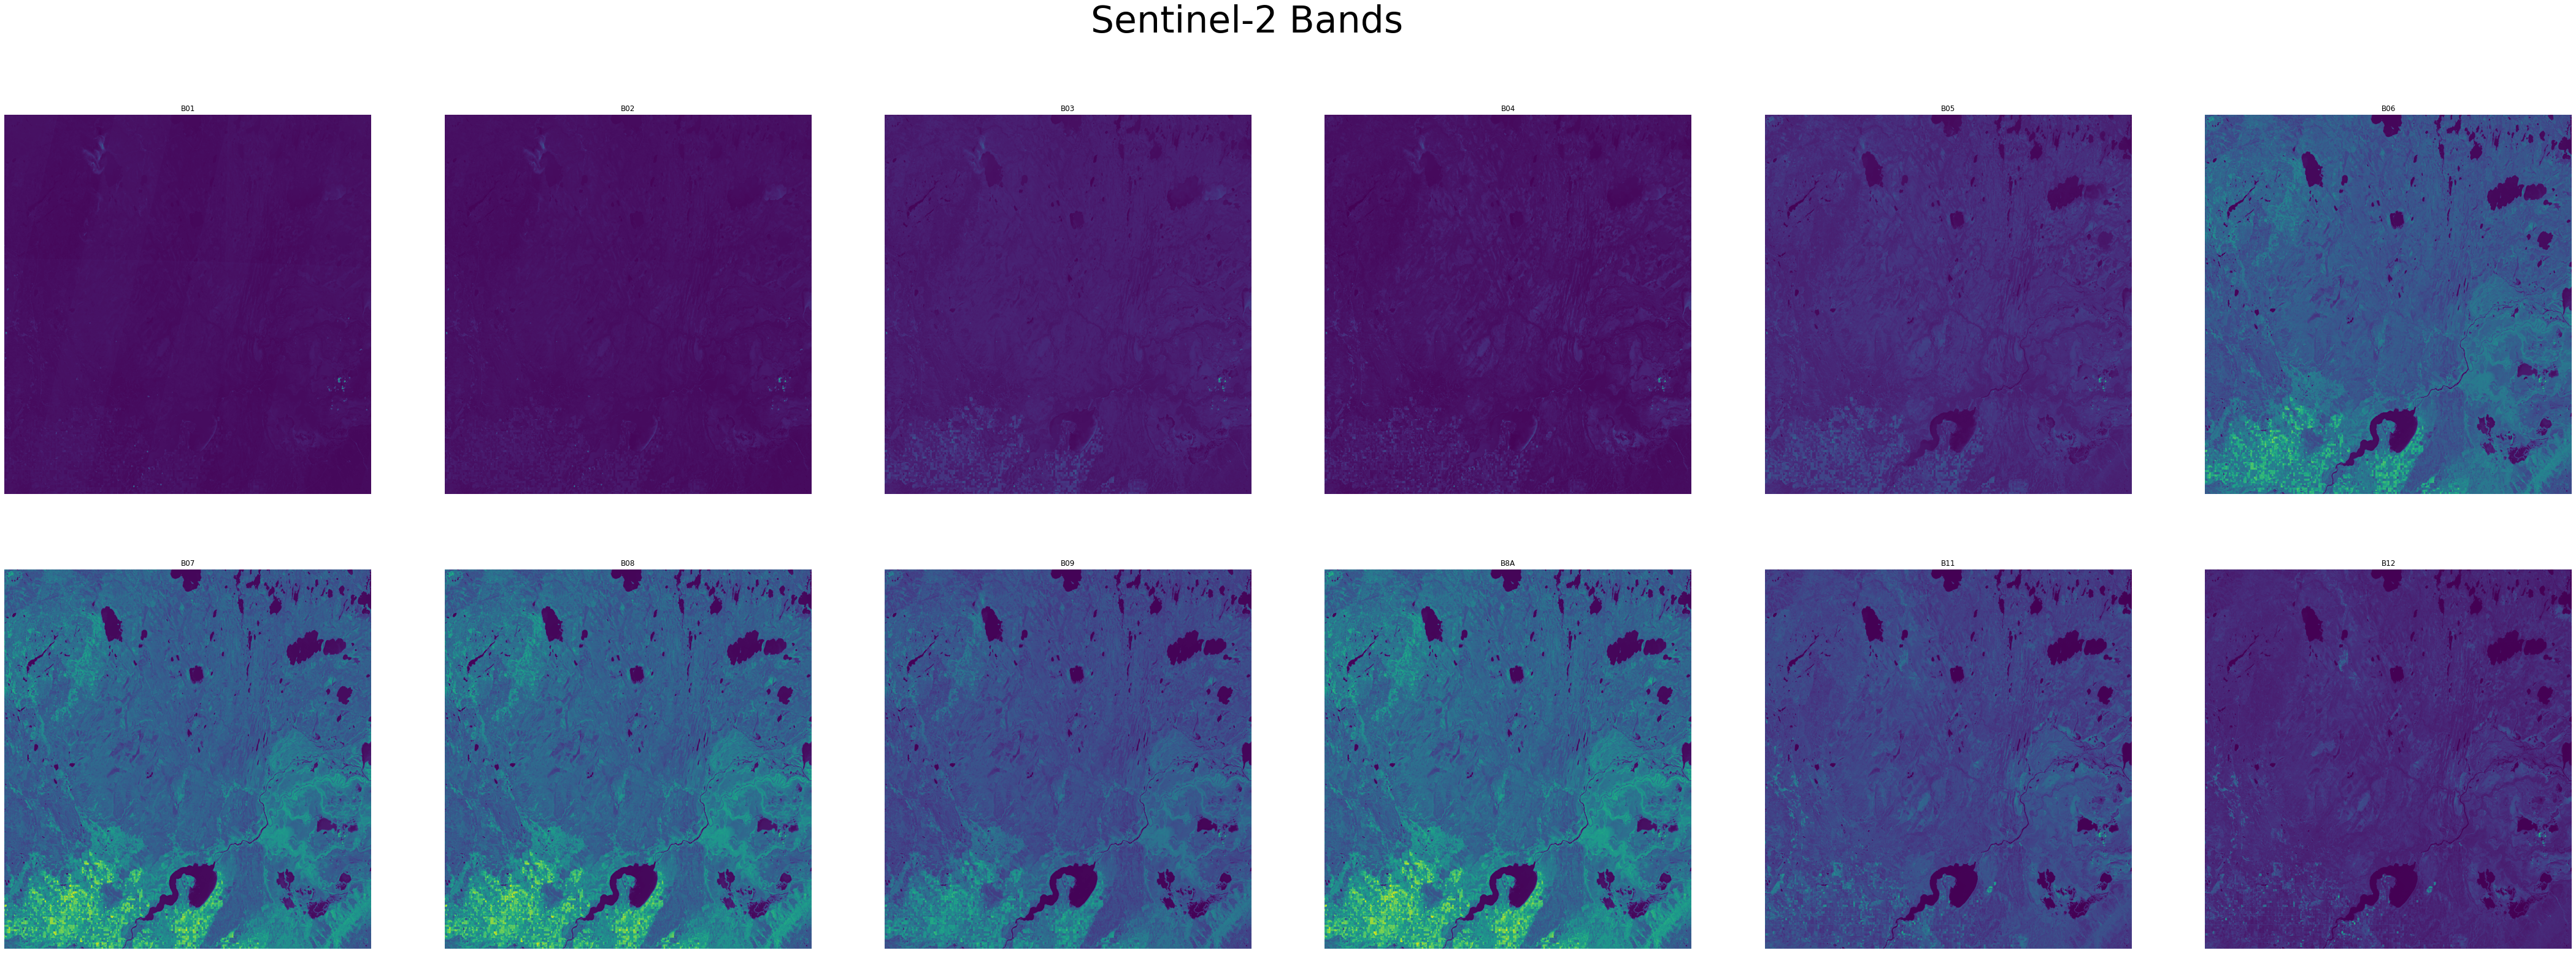

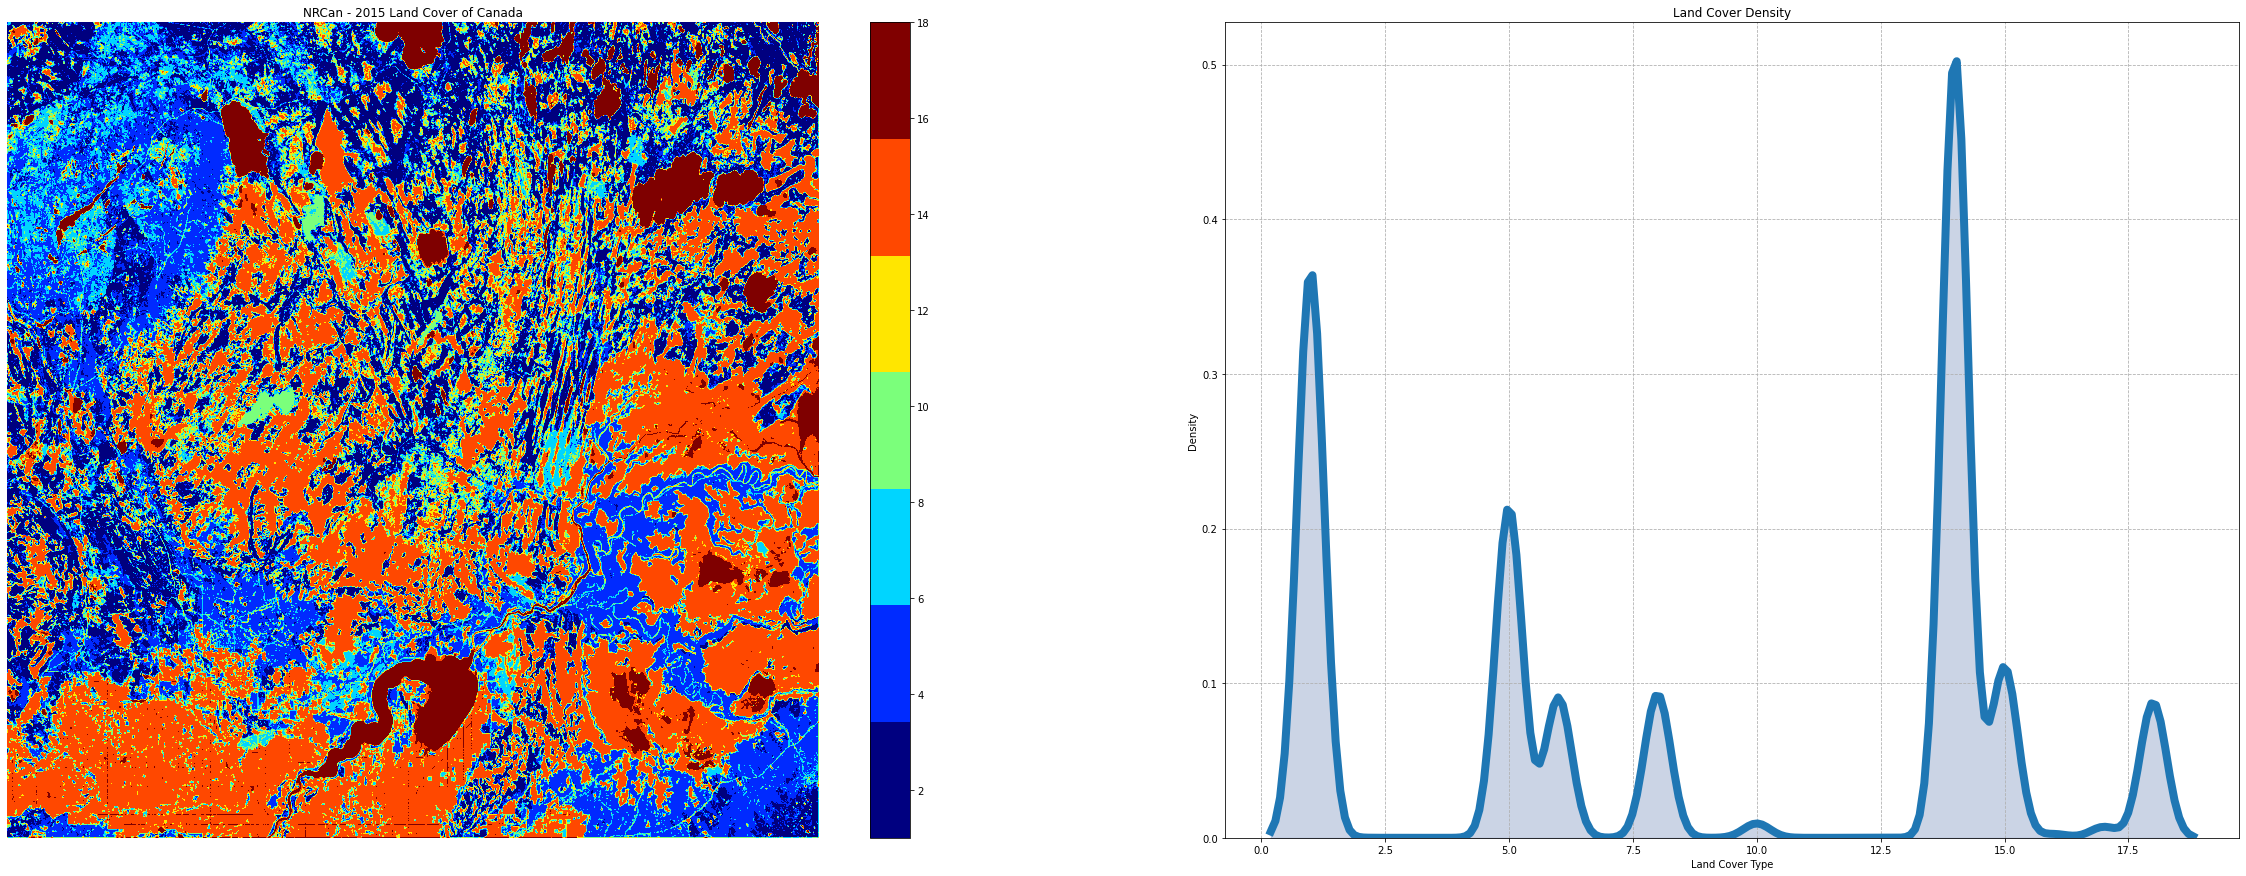

In [6]:
#### Example plotting functions to display S2 data in Python

def show_band_matrix():
    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(75,25))
    plt.suptitle("Sentinel-2 Bands", fontsize=60)
    band_count = 1
    df = df_bands
    for i,ax_row in enumerate(axes):
        for j, ax_col in enumerate(ax_row):
            if i == 1 and j == 3: # Special case for 8a band
                title = 'B8A'
                imband = np.asarray(df[title]).reshape(2500, 2100).T
                band_count += 1
            else: # Individual bands
                title = 'B' + str(band_count).zfill(2)
                imband = np.asarray(df[title]).reshape(2500, 2100).T
                band_count += 1
            
            axes[i][j].set_title(title)
            axes[i][j].imshow(imband, aspect='auto')
            axes[i][j].set_axis_off()

def show_land_cover():
    df = df_classes
    fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(40,15))
    ax.set_title("NRCan - 2015 Land Cover of Canada")
    cmap = cm.get_cmap('jet', 7)    # 11 discrete colors
    im = ax.imshow(np.asarray(df.land_cover).reshape(2500, 2100).T, cmap=cmap, aspect='auto')
    ax.set_axis_off()
    cbar = plt.colorbar(im, ax=ax)
    
    ax2.grid(linestyle='--')
    dp = sns.distplot(df.land_cover, hist=False, kde_kws=dict(linewidth=8))
    l1 = ax2.lines[0]
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax2.fill_between(x1,y1, color="#5471ab", alpha=0.3)
    ax2.set_xlabel("Land Cover Type")
    ax2.set_title("Land Cover Density")

show_band_matrix()
show_land_cover()



Since our model was trained on standardized input covarites, we should do the same here for testing. Make sure you are standardizing your input data using the same methods here (this is the only preprocessing we apply).

If you are using a CNN or require any other preprocessing of the data we have provided here, you'll want to do that now. If you need to reformat the input to a matrix like we've shown above, you can do so here. Or if you want to generate other derived bands like NDVI etc. from the raw bands provided, you may do so here. Make sure you include whatever preprocessing code you are using here in your submission to the competition, because again, it needs to work with just the example input we provided here.

In [5]:
#### Insert any additional preprocessing code here
#Functions for Pipeline
def add_layers(df):
  """
  This function takes in a dataframe and calculates the NDVI, Moisture Index, NDWI and NDSI
  Outputs = dataframe with added layer columns 
  """
  #Create NDVI column (B08-B04)/(B08+B04)
  df['NDVI'] = (df.B08 - df.B04)/(df.B08 + df.B04)
  #Create Moisture index (B8A-B11)/(B8A+B11)
  df['Moisture'] = (df.B8A - df.B11)/(df.B8A + df.B11)
  #Create NDWI (B3-B8)/(B3+B8)
  df['NDWI'] = (df.B03 - df.B08)/(df.B03 + df.B08)
  #create NDSI (B3-B11)/(B3+B11)
  df['NDSI'] = (df.B03 - df.B11)/(df.B03 + df.B11)

  return df

def replace_values(df):
  """
  This function replaces the infinity values with Nan then replaces that with new infinity values
  """
  #Replace infinity values with Nan
  df.replace([np.inf, -np.inf], np.NAN, inplace=True)

  #Fill in null values
  df.fillna(999, inplace=True)

  return df


#Define object transformer class
class objectTransformer:
    """
    Class object transformer, takes in function to apply in preprocessing step of Pipeline
    """
    def __init__(self, func):
        self.func = func
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **fit_params):
        return self.func(X)


In [12]:
#### Create X and y variables for data splitting
y = df_classes
X = df_bands

# Standardize features by removing the mean and scaling to unit variance
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [14]:
#### Print out data shapes
print(X.shape)
print(y.shape)

(5250000, 12)
(5250000, 1)


**Add your model!** 

In [11]:
#### Load in your model for testing here

YOUR_MODEL_PATH = '/content/drive/MyDrive/model.pickle'

clf = pickle.load(open(YOUR_MODEL_PATH, 'rb'))

How did we do? Let's check our accuracy:

In [15]:
#### Predict and check skill
y_pred = clf.predict(X)

print("Accuracy:", metrics.accuracy_score(y, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Accuracy: 0.17246704761904763


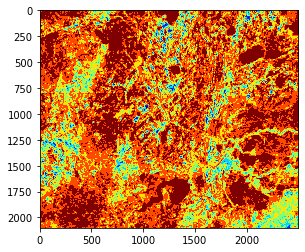

In [16]:
#plot demo prediction map
map_pred = np.asarray(y_pred).reshape(2500, 2100).T
cmap = cm.get_cmap('jet', 7)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)


Great job! If your model ran on the provided example data, you can submit the pickled classifier to me via email (fdmking@uwaterloo) with a description of how it was developed and you will be formally entered in the contest! For more details, please see our working group landing page: https://community.ai.science/ml-applications-for-land-cover-classification-using-sentinel-2
